# IMPORTING NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error
from math import sqrt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LOADING THE DATASET

In [2]:
data = pd.read_csv('iot_load_data.csv')

# VIEWING THE DATASET

## To display the contents of the Dataset by accessing the pandas Dataframe named data.

In [3]:
data

Timestamp  Electricity_Load  Temperature  Humidity  Day_of_Week  \
0      1/1/2015               753            2        69            3   
1      1/2/2015               872           14        26            4   
2      1/3/2015               525           19        73            5   
3      1/4/2015               568           23        59            6   
4      1/5/2015               636           28        32            0   
...         ...               ...          ...       ...          ...   
3312  1/26/2024               626            7        78            4   
3313  1/27/2024               660           28        76            5   
3314  1/28/2024               902           -6        71            6   
3315  1/29/2024               805            8        50            0   
3316  1/30/2024               510           -2        69            1   

     Time_of_Day  Holiday_Indicator  Previous_Load  Transportation_Data  \
0      Afternoon                  1            812                   25   
1        Evening                  0            963                   25   
2      Afternoon                  0            753                   11   
3        Morning                  0            839                   16   
4      Afternoon                  0            505                   24   
...          ...                ...            ...                  ...   
3312       Night                  0            999                   21   
3313   Afternoon                  0            589                   31   
3314     Morning                  0            930                   37   
3315     Morning                  0            809                   46   
3316       Night                  0            765                   18   

      Operational_Metrics  ...  Real_Time_LMP Regulation_Capacity  \
0                     201  ...      25.141389                  82   
1                     139  ...      20.703909                  75   
2                     497  ...      46.367384                  87   
3                     464  ...      49.862441                  54   
4                     142  ...      34.631596                  97   
...                   ...  ...            ...                 ...   
3312                  370  ...      27.195047                  63   
3313                  328  ...      36.020884                  72   
3314                  174  ...      30.789353                  94   
3315                  300  ...      27.124485                  83   
3316                  475  ...      23.728788                  69   

      Day_Ahead_LMP  Day_Ahead_EC  Day_Ahead_CC  Day_Ahead_MLC  Real_Time_EC  \
0         33.526050     13.661695      4.339328       1.568146     18.903664   
1         44.547889      6.118156      8.685590       4.317611     22.458212   
2         37.807827      8.405380      6.072040       3.776703     13.400587   
3         41.700664      9.233539      4.299356       1.900629     16.558408   
4         56.762892      8.772969      2.025394       2.949036     20.760512   
...             ...           ...           ...            ...           ...   
3312      35.802869     10.500677      4.967594       4.431077     18.111913   
3313      46.833236     12.254291      8.682905       4.596308     22.941873   
3314      56.911530      9.448063      7.176258       1.941599     24.453996   
3315      32.712592     11.144807      5.621015       3.288789     17.424410   
3316      59.104685      7.906216      6.554054       3.143045     14.849659   

      Real_Time_CC  Real_Time_MLC  System_Load  
0         4.407353       1.385887          518  
1         5.615720       2.689898          503  
2         1.741812       1.610319          897  
3         3.974303       2.798738          526  
4         4.140475       1.041746          958  
...            ...            ...          ...  
3312      2.602763       2.682778          603  
3313      4.375059       1.208422          966

## data.describe()  summarizes our data in `data`. It provides statistics like mean, standard deviation for numerical columns, helping us to understand data spread.

In [4]:
data.describe()

Electricity_Load  Temperature     Humidity  Day_of_Week  \
count       3317.000000  3317.000000  3317.000000  3317.000000   
mean         747.139584    11.826349    49.235454     3.000301   
std          146.200936    13.148406    17.240328     2.000528   
min          500.000000   -10.000000    20.000000     0.000000   
25%          617.000000     0.000000    34.000000     1.000000   
50%          745.000000    12.000000    49.000000     3.000000   
75%          876.000000    23.000000    64.000000     5.000000   
max          999.000000    34.000000    79.000000     6.000000   

       Holiday_Indicator  Previous_Load  Transportation_Data  \
count        3317.000000    3317.000000          3317.000000   
mean            0.048538     751.699427            29.362376   
std             0.214932     144.082078            11.612803   
min             0.000000     500.000000            10.000000   
25%             0.000000     627.000000            19.000000   
50%             0.000000     758.000000            29.000000   
75%             0.000000     873.000000            40.000000   
max             1.000000     999.000000            49.000000   

       Operational_Metrics  IoT_Sensor_Data  Day_Ahead_Demand  Real_Time_LMP  \
count          3317.000000      3317.000000       3317.000000    3317.000000   
mean            295.124812         0.509727        749.904130      35.171084   
std             116.643478         0.287211        144.539798       8.588138   
min             100.000000         0.000087        500.000000      20.003618   
25%             193.000000         0.263194        624.000000      27.738568   
50%             292.000000         0.517017        752.000000      35.305189   
75%             396.000000         0.751797        873.000000      42.654407   
max             499.000000         0.999721        999.000000      49.991381   

       Regulation_Capacity  Day_Ahead_LMP  Day_Ahead_EC  Day_Ahead_CC  \
count          3317.000000    3317.000000   3317.000000   3317.000000   
mean             74.675912      45.072769     12.571673      5.998729   
std              14.375360       8.605591      4.364806      2.323864   
min              50.000000      30.013604      5.001610      2.000390   
25%              62.000000      37.702070      8.776196      3.963846   
50%              74.000000      45.082810     12.497490      5.976482   
75%              87.000000      52.619184     16.408129      7.965606   
max              99.000000      59.999975     19.999923      9.993948   

       Day_Ahead_MLC  Real_Time_EC  Real_Time_CC  Real_Time_MLC  System_Load  
count    3317.000000   3317.000000   3317.000000    3317.000000  3317.000000  
mean        2.986179     17.396839      4.502918       1.740272   746.485680  
std         1.145995      4.316407      2.007996       0.722434   143.063957  
min         1.000619     10.003937      1.001908       0.501369   500.000000  
25%         1.994952     13.715226      2.804991       1.106576   623.000000  
50%         2.990367     17.277678      4.459715       1.720833   746.000000  
75%         3.949633     21.061795      6.235036       2.368313   870.000000  
max         4.997086     24.997505      7.991799       2.999871   999.000000

## data.info() in Pandas gives us a quick peek at our data's structure. It shows details like number of rows, columns, data types, memory usage and missing values.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            3317 non-null   object 
 1   Electricity_Load     3317 non-null   int64  
 2   Temperature          3317 non-null   int64  
 3   Humidity             3317 non-null   int64  
 4   Day_of_Week          3317 non-null   int64  
 5   Time_of_Day          3317 non-null   object 
 6   Holiday_Indicator    3317 non-null   int64  
 7   Previous_Load        3317 non-null   int64  
 8   Transportation_Data  3317 non-null   int64  
 9   Operational_Metrics  3317 non-null   int64  
 10  IoT_Sensor_Data      3317 non-null   float64
 11  External_Factors     3317 non-null   object 
 12  Day_Ahead_Demand     3317 non-null   int64  
 13  Real_Time_LMP        3317 non-null   float64
 14  Regulation_Capacity  3317 non-null   int64  
 15  Day_Ahead_LMP        3317 non-null   f

# DATA PREPROCESSING

## To determine the preprocessing and data cleaning steps required for the dataset in `iot_load_data.csv`, We first inspected the data to identify any potential issues such as missing values, incorrect data types, outliers, or inconsistencies.

### Step 1: Check for missing values in each column and removing them if any

In [6]:
data_missing_values = data.isnull().sum()

print('\Missing Values in Each Column:')
print(data_missing_values)

\Missing Values in Each Column:
Timestamp              0
Electricity_Load       0
Temperature            0
Humidity               0
Day_of_Week            0
Time_of_Day            0
Holiday_Indicator      0
Previous_Load          0
Transportation_Data    0
Operational_Metrics    0
IoT_Sensor_Data        0
External_Factors       0
Day_Ahead_Demand       0
Real_Time_LMP          0
Regulation_Capacity    0
Day_Ahead_LMP          0
Day_Ahead_EC           0
Day_Ahead_CC           0
Day_Ahead_MLC          0
Real_Time_EC           0
Real_Time_CC           0
Real_Time_MLC          0
System_Load            0
dtype: int64


In [7]:
data_missing_values = data_missing_values[data_missing_values > 0]

if not data_missing_values.empty:
    for column in data_missing_values.index:
        if data[column].dtype == 'object':
            data[column] = data[column].fillna(data[column].mode()[0])
        else:
            data[column] = data[column].fillna(data[column].median())
    print('Missing values have been handled.')
else:
    print('No missing values to handle.')

No missing values to handle.



### Step 2: The 'Timestamp' column is recognized as an object type, which suggests it is stored as a string. This has been converted to a datetime type for our forecasting model  and checked we whether it has been updated.

In [8]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data['Year'] = data['Timestamp'].dt.year

# Confirm the conversion
data_types = data.dtypes
print('Updated Data Types:')
print(data_types)

Updated Data Types:
Timestamp              datetime64[ns]
Electricity_Load                int64
Temperature                     int64
Humidity                        int64
Day_of_Week                     int64
Time_of_Day                    object
Holiday_Indicator               int64
Previous_Load                   int64
Transportation_Data             int64
Operational_Metrics             int64
IoT_Sensor_Data               float64
External_Factors               object
Day_Ahead_Demand                int64
Real_Time_LMP                 float64
Regulation_Capacity             int64
Day_Ahead_LMP                 float64
Day_Ahead_EC                  float64
Day_Ahead_CC                  float64
Day_Ahead_MLC                 float64
Real_Time_EC                  float64
Real_Time_CC                  float64
Real_Time_MLC                 float64
System_Load                     int64
Day                             int32
Month                           int32
Year                          

### Step 3: Checking for outliers in numerical columns to ensure data quality and we applied Capping outliers,it is a technique used in data analysis to address extreme values that fall outside the typical range of the data. It involves setting thresholds and replacing outlier values with those thresholds.

In [9]:
# Check for outliers using the IQR method
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Apply outlier detection to a few numerical columns
outliers_electricity = detect_outliers(data, 'Electricity_Load')
outliers_temperature = detect_outliers(data, 'Temperature')
outliers_humidity = detect_outliers(data, 'Humidity')

print('Outliers in Electricity Load:')
print(outliers_electricity)
print('\nOutliers in Temperature:')
print(outliers_temperature)
print('\nOutliers in Humidity:')
print(outliers_humidity)

Outliers in Electricity Load:
Empty DataFrame
Columns: [Timestamp, Electricity_Load, Temperature, Humidity, Day_of_Week, Time_of_Day, Holiday_Indicator, Previous_Load, Transportation_Data, Operational_Metrics, IoT_Sensor_Data, External_Factors, Day_Ahead_Demand, Real_Time_LMP, Regulation_Capacity, Day_Ahead_LMP, Day_Ahead_EC, Day_Ahead_CC, Day_Ahead_MLC, Real_Time_EC, Real_Time_CC, Real_Time_MLC, System_Load, Day, Month, Year]
Index: []

[0 rows x 26 columns]

Outliers in Temperature:
Empty DataFrame
Columns: [Timestamp, Electricity_Load, Temperature, Humidity, Day_of_Week, Time_of_Day, Holiday_Indicator, Previous_Load, Transportation_Data, Operational_Metrics, IoT_Sensor_Data, External_Factors, Day_Ahead_Demand, Real_Time_LMP, Regulation_Capacity, Day_Ahead_LMP, Day_Ahead_EC, Day_Ahead_CC, Day_Ahead_MLC, Real_Time_EC, Real_Time_CC, Real_Time_MLC, System_Load, Day, Month, Year]
Index: []

[0 rows x 26 columns]

Outliers in Humidity:
Empty DataFrame
Columns: [Timestamp, Electricity_Load

In [10]:
# Handling outliers by capping them to the upper and lower bounds
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
    return data

data = cap_outliers(data, 'Electricity_Load')
data = cap_outliers(data, 'Temperature')
data = cap_outliers(data, 'Humidity')

print('Outliers have been capped for Electricity Load, Temperature, and Humidity.')

Outliers have been capped for Electricity Load, Temperature, and Humidity.


### Step 4: Standardizing categorical data by ensuring consistent casing and removing any leading/trailing spaces

In [11]:
data['Time_of_Day'] = data['Time_of_Day'].str.strip().str.lower()
data['External_Factors'] = data['External_Factors'].str.strip().str.lower()

unique_time_of_day = data['Time_of_Day'].unique()
unique_external_factors = data['External_Factors'].unique()

print('Unique Time of Day categories after standardization:')
print(unique_time_of_day)
print('\nUnique External Factors categories after standardization:')
print(unique_external_factors)

Unique Time of Day categories after standardization:
['afternoon' 'evening' 'morning' 'night']

Unique External Factors categories after standardization:
['regulatory' 'other' 'economic']


In [12]:
le = LabelEncoder()

data['Time_of_Day_encoded'] = le.fit_transform(data['Time_of_Day'])
data['External_Factors_encoded'] = le.fit_transform(data['External_Factors'])

In [13]:
data

Timestamp  Electricity_Load  Temperature  Humidity  Day_of_Week  \
0    2015-01-01               753            2        69            3   
1    2015-01-02               872           14        26            4   
2    2015-01-03               525           19        73            5   
3    2015-01-04               568           23        59            6   
4    2015-01-05               636           28        32            0   
...         ...               ...          ...       ...          ...   
3312 2024-01-26               626            7        78            4   
3313 2024-01-27               660           28        76            5   
3314 2024-01-28               902           -6        71            6   
3315 2024-01-29               805            8        50            0   
3316 2024-01-30               510           -2        69            1   

     Time_of_Day  Holiday_Indicator  Previous_Load  Transportation_Data  \
0      afternoon                  1            812                   25   
1        evening                  0            963                   25   
2      afternoon                  0            753                   11   
3        morning                  0            839                   16   
4      afternoon                  0            505                   24   
...          ...                ...            ...                  ...   
3312       night                  0            999                   21   
3313   afternoon                  0            589                   31   
3314     morning                  0            930                   37   
3315     morning                  0            809                   46   
3316       night                  0            765                   18   

      Operational_Metrics  ...  Day_Ahead_MLC Real_Time_EC  Real_Time_CC  \
0                     201  ...       1.568146    18.903664      4.407353   
1                     139  ...       4.317611    22.458212      5.615720   
2                     497  ...       3.776703    13.400587      1.741812   
3                     464  ...       1.900629    16.558408      3.974303   
4                     142  ...       2.949036    20.760512      4.140475   
...                   ...  ...            ...          ...           ...   
3312                  370  ...       4.431077    18.111913      2.602763   
3313                  328  ...       4.596308    22.941873      4.375059   
3314                  174  ...       1.941599    24.453996      7.705989   
3315                  300  ...       3.288789    17.424410      7.444762   
3316                  475  ...       3.143045    14.849659      1.863989   

      Real_Time_MLC  System_Load  Day  Month  Year  Time_of_Day_encoded  \
0          1.385887          518    1      1  2015                    0   
1          2.689898          503    2      1  2015                    1   
2          1.610319          897    3      1  2015                    0   
3          2.798738          526    4      1  2015                    2   
4          1.041746          958    5      1  2015                    0   
...             ...          ...  ...    ...   ...                  ...   
3312       2.682778          603   26      1  2024                    3   
3313       1.208422          966   27      1  2024                    0   
3314       1.280677          745   28      1  2024                    2   
3315       2.076614          698   29      1  2024                    2   
3316       2.956020          840   30      1  2024                    3   

      External_Factors_encoded  
0                            2  
1                            1  
2                            0  
3                            2  
4                            2  
...                        ...  
3312                         1  
3313                         1  
3314                         2  
3315                         0  
3316                         2  

[3317 rows x 28 c

# Performing exploratory data analysis (EDA)

## Histograms of Numerical Columns: This visualization shows the distribution of values in the numerical columns

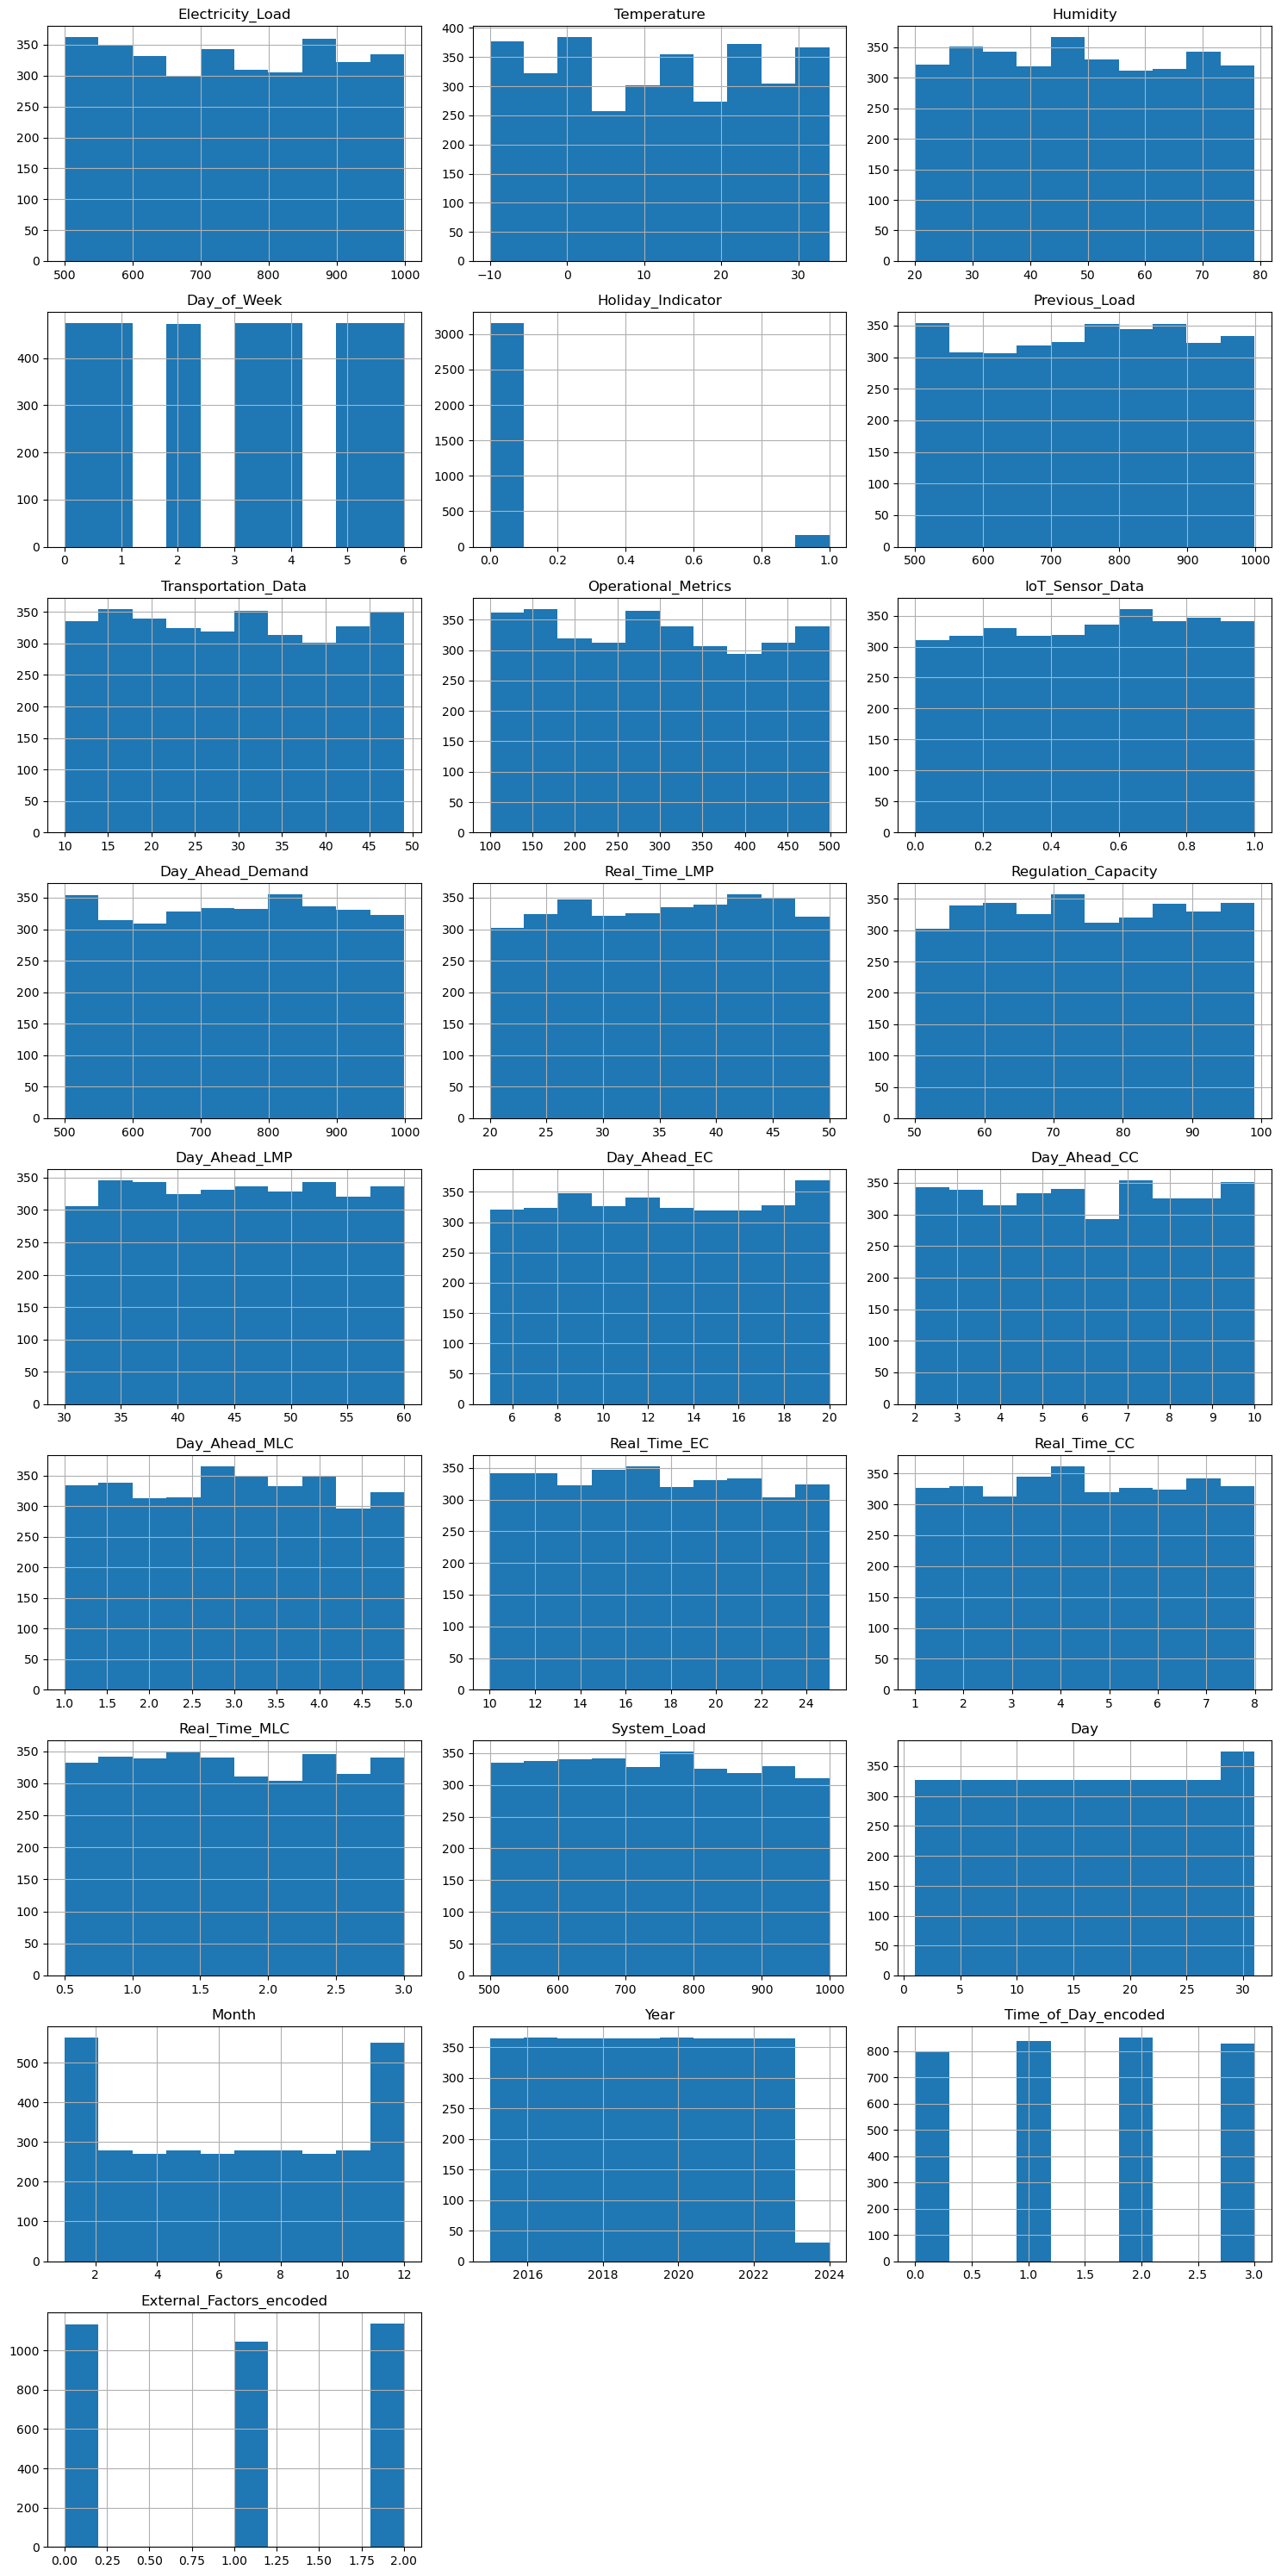

In [14]:
numerical_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]

fig, axes = plt.subplots(nrows=int((len(numerical_cols) - 1) / 3) + 1, ncols=3, figsize=(15, 30))  

for i, col in enumerate(numerical_cols):
    ax = axes.flat[i]  
    data[col].hist(ax=ax)
    ax.set_title(col)
    ax.grid(True)

for ax in axes.flat[len(numerical_cols):]:
    ax.axis('off')

# Show the plot
plt.tight_layout() 
plt.show()

## Boxplots of Numerical Columns of key variables: These boxplots provide a view of the central tendency and spread of the numerical data, along with any remaining outliers after capping.

<Figure size 640x480 with 0 Axes>

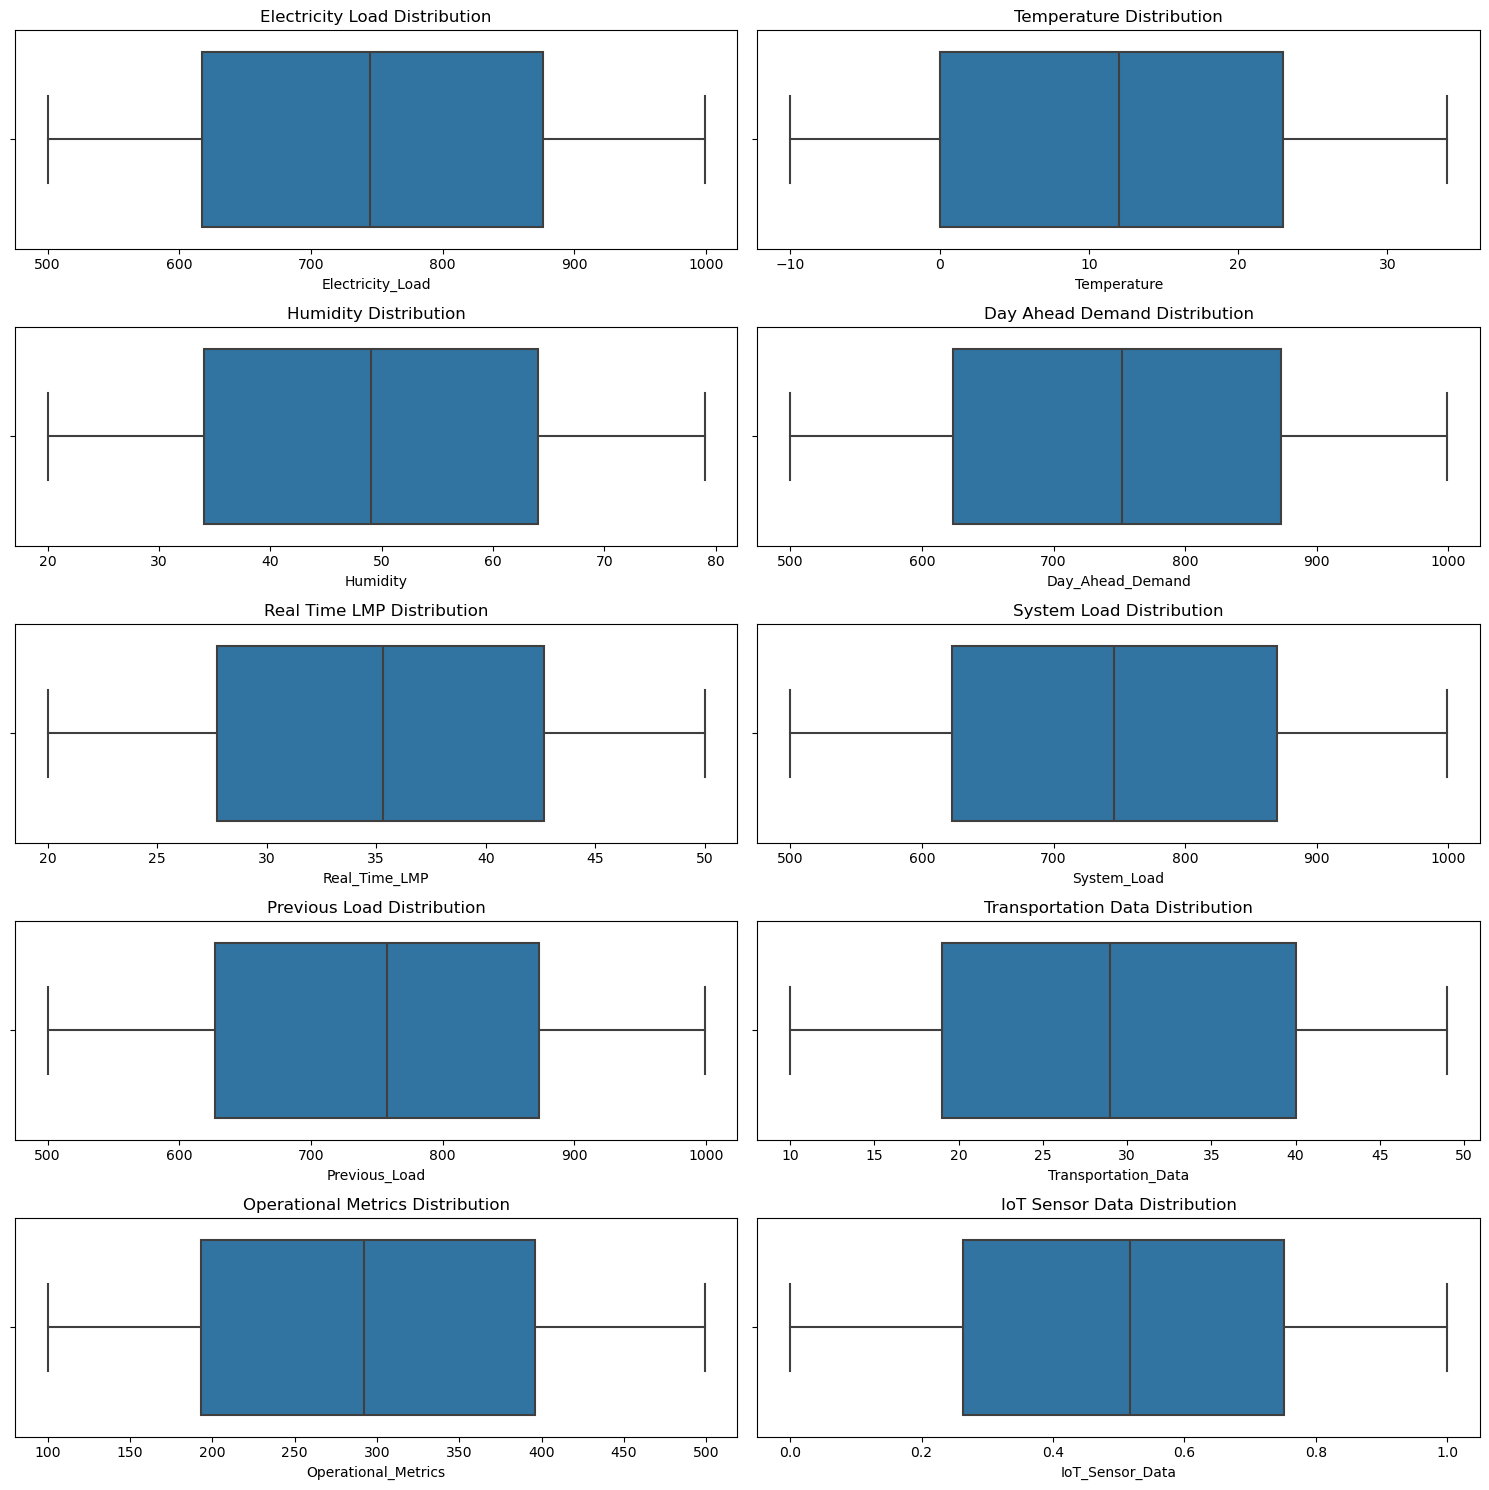

In [15]:
plt.figure(facecolor='white')

fig, axes = plt.subplots(5, 2, figsize=(15, 15))

sns.boxplot(ax=axes[0, 0], x=data['Electricity_Load'])
axes[0, 0].set_title('Electricity Load Distribution')

sns.boxplot(ax=axes[0, 1], x=data['Temperature'])
axes[0, 1].set_title('Temperature Distribution')

sns.boxplot(ax=axes[1, 0], x=data['Humidity'])
axes[1, 0].set_title('Humidity Distribution')

sns.boxplot(ax=axes[1, 1], x=data['Day_Ahead_Demand'])
axes[1, 1].set_title('Day Ahead Demand Distribution')

sns.boxplot(ax=axes[2, 0], x=data['Real_Time_LMP'])
axes[2, 0].set_title('Real Time LMP Distribution')

sns.boxplot(ax=axes[2, 1], x=data['System_Load'])
axes[2, 1].set_title('System Load Distribution')

sns.boxplot(ax=axes[3, 0], x=data['Previous_Load'])
axes[3, 0].set_title('Previous Load Distribution')

sns.boxplot(ax=axes[3, 1], x=data['Transportation_Data'])
axes[3, 1].set_title('Transportation Data Distribution')

sns.boxplot(ax=axes[4, 0], x=data['Operational_Metrics'])
axes[4, 0].set_title('Operational Metrics Distribution')

sns.boxplot(ax=axes[4, 1], x=data['IoT_Sensor_Data'])
axes[4, 1].set_title('IoT Sensor Data Distribution')

plt.tight_layout()
plt.show()

## Visualizing the distribution of key variables to understand their spread and central tendency better using Histograms.

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

<Figure size 640x480 with 0 Axes>

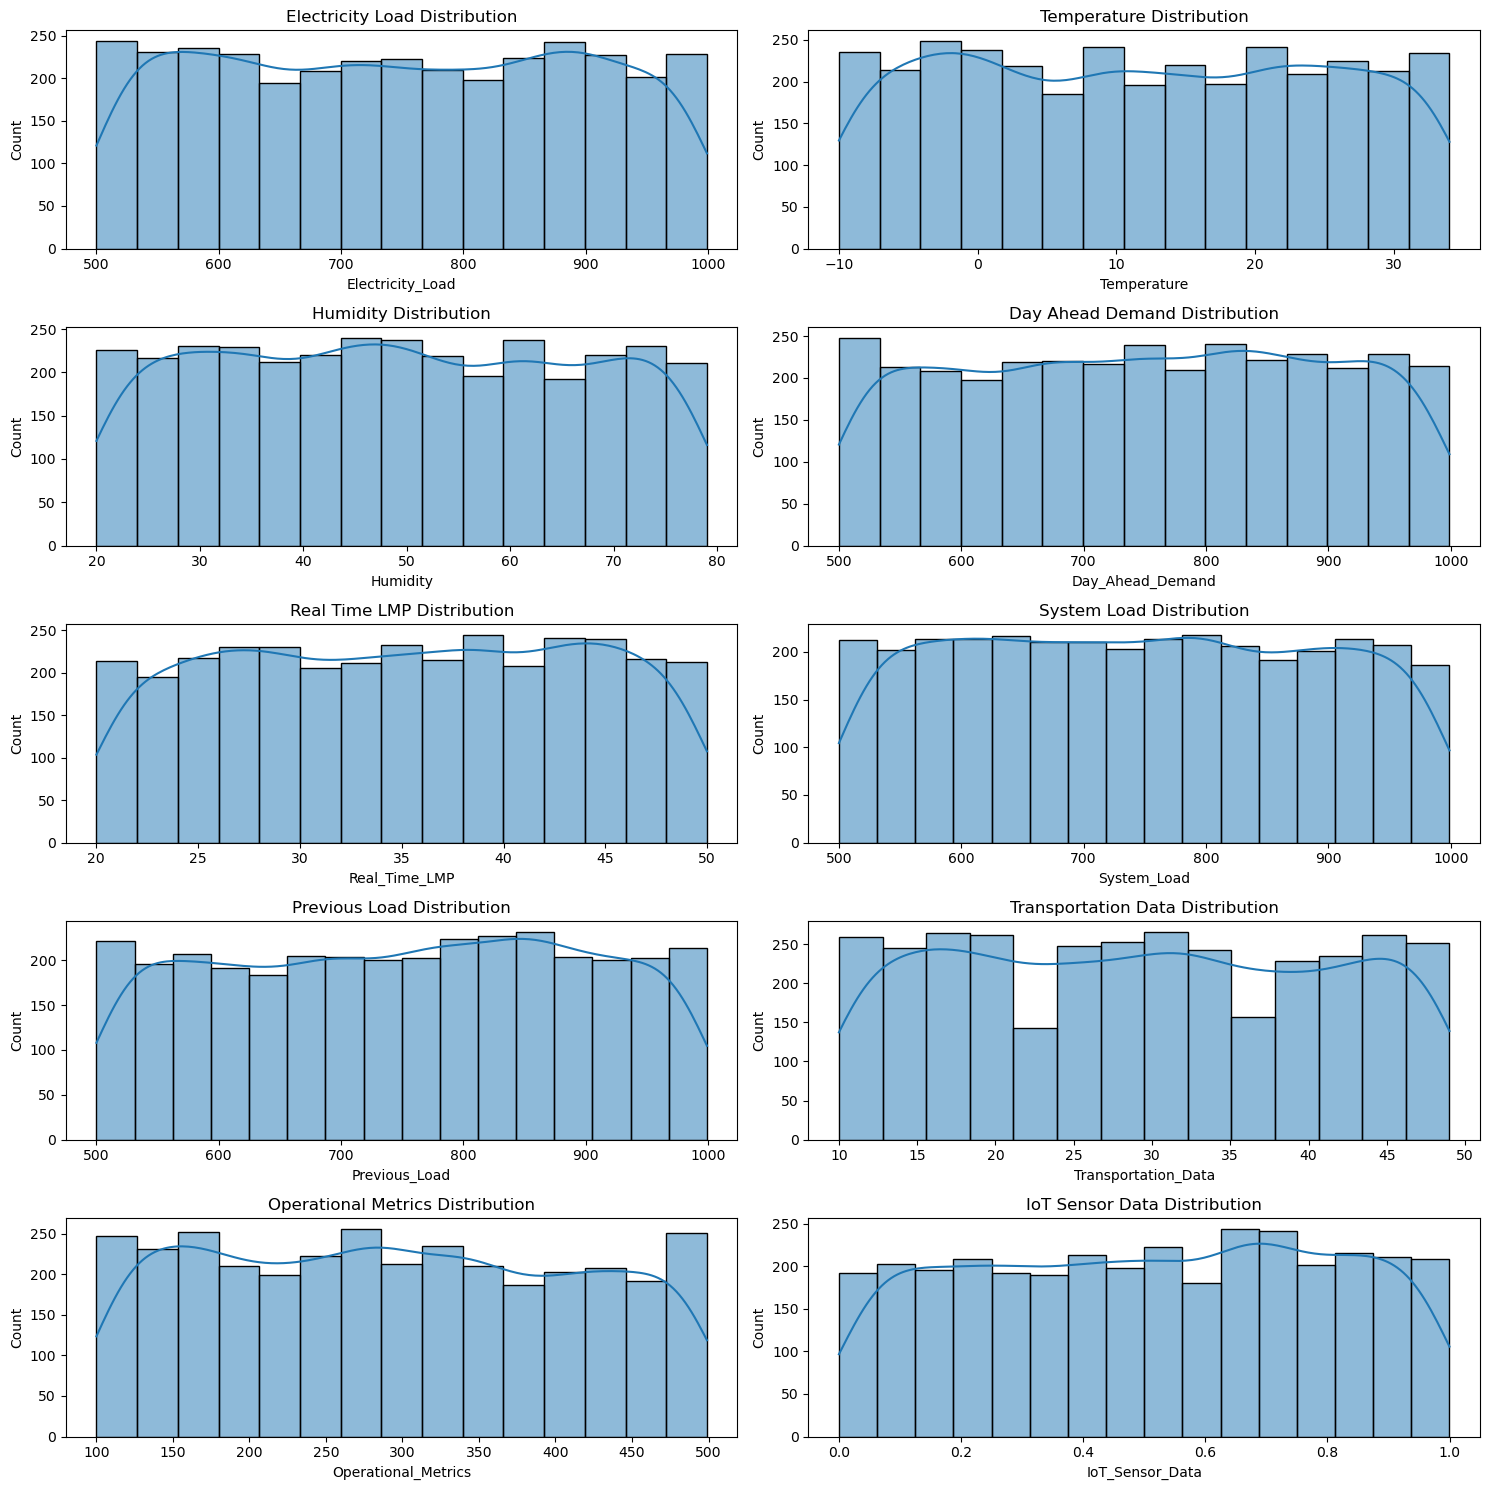

In [16]:
plt.figure(facecolor='white')

fig, axes = plt.subplots(5, 2, figsize=(15, 15))

sns.histplot(ax=axes[0, 0], x=data['Electricity_Load'], kde=True)
axes[0, 0].set_title('Electricity Load Distribution')

sns.histplot(ax=axes[0, 1], x=data['Temperature'], kde=True)
axes[0, 1].set_title('Temperature Distribution')

sns.histplot(ax=axes[1, 0], x=data['Humidity'], kde=True)
axes[1, 0].set_title('Humidity Distribution')

sns.histplot(ax=axes[1, 1], x=data['Day_Ahead_Demand'], kde=True)
axes[1, 1].set_title('Day Ahead Demand Distribution')

sns.histplot(ax=axes[2, 0], x=data['Real_Time_LMP'], kde=True)
axes[2, 0].set_title('Real Time LMP Distribution')

sns.histplot(ax=axes[2, 1], x=data['System_Load'], kde=True)
axes[2, 1].set_title('System Load Distribution')

sns.histplot(ax=axes[3, 0], x=data['Previous_Load'], kde=True)
axes[3, 0].set_title('Previous Load Distribution')

sns.histplot(ax=axes[3, 1], x=data['Transportation_Data'], kde=True)
axes[3, 1].set_title('Transportation Data Distribution')

sns.histplot(ax=axes[4, 0], x=data['Operational_Metrics'], kde=True)
axes[4, 0].set_title('Operational Metrics Distribution')

sns.histplot(ax=axes[4, 1], x=data['IoT_Sensor_Data'], kde=True)
axes[4, 1].set_title('IoT Sensor Data Distribution')

plt.tight_layout()
plt.show()

## Count plots for categorical columns

<Figure size 640x480 with 0 Axes>

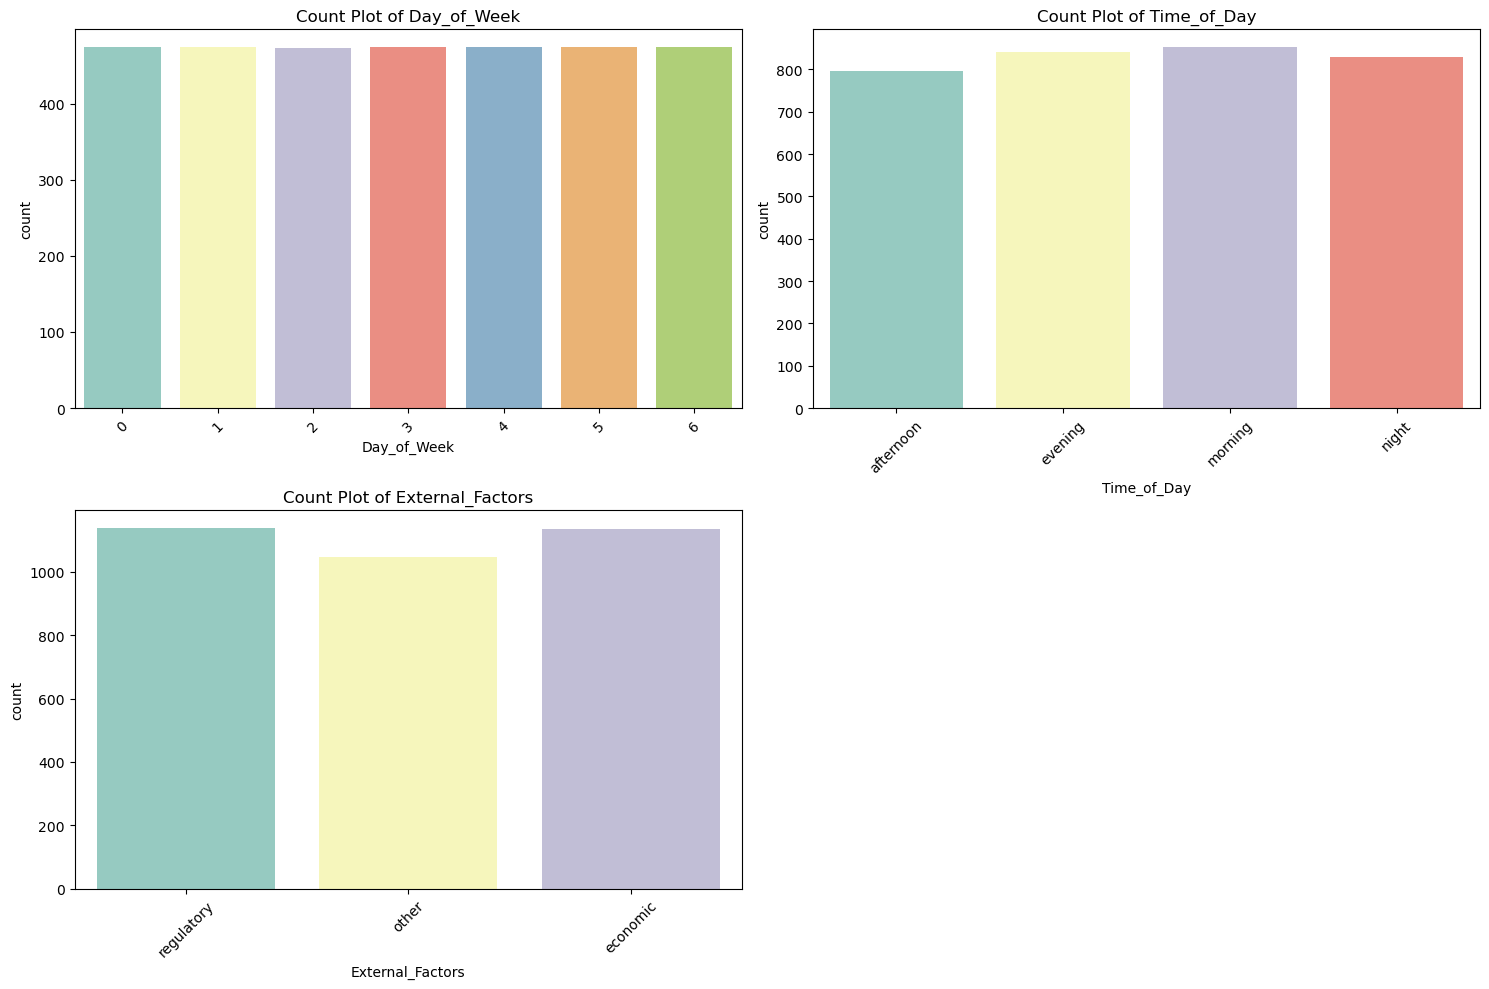

In [17]:
plt.figure(facecolor='white')

categorical_columns = ['Day_of_Week', 'Time_of_Day', 'External_Factors']
plt.figure(figsize=(15, 10), facecolor='white')
for i, column in enumerate(categorical_columns):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=column, data=data, palette='Set3')
    plt.title('Count Plot of ' + column)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

## Analyzing the correlations between these variables to understand their relationships

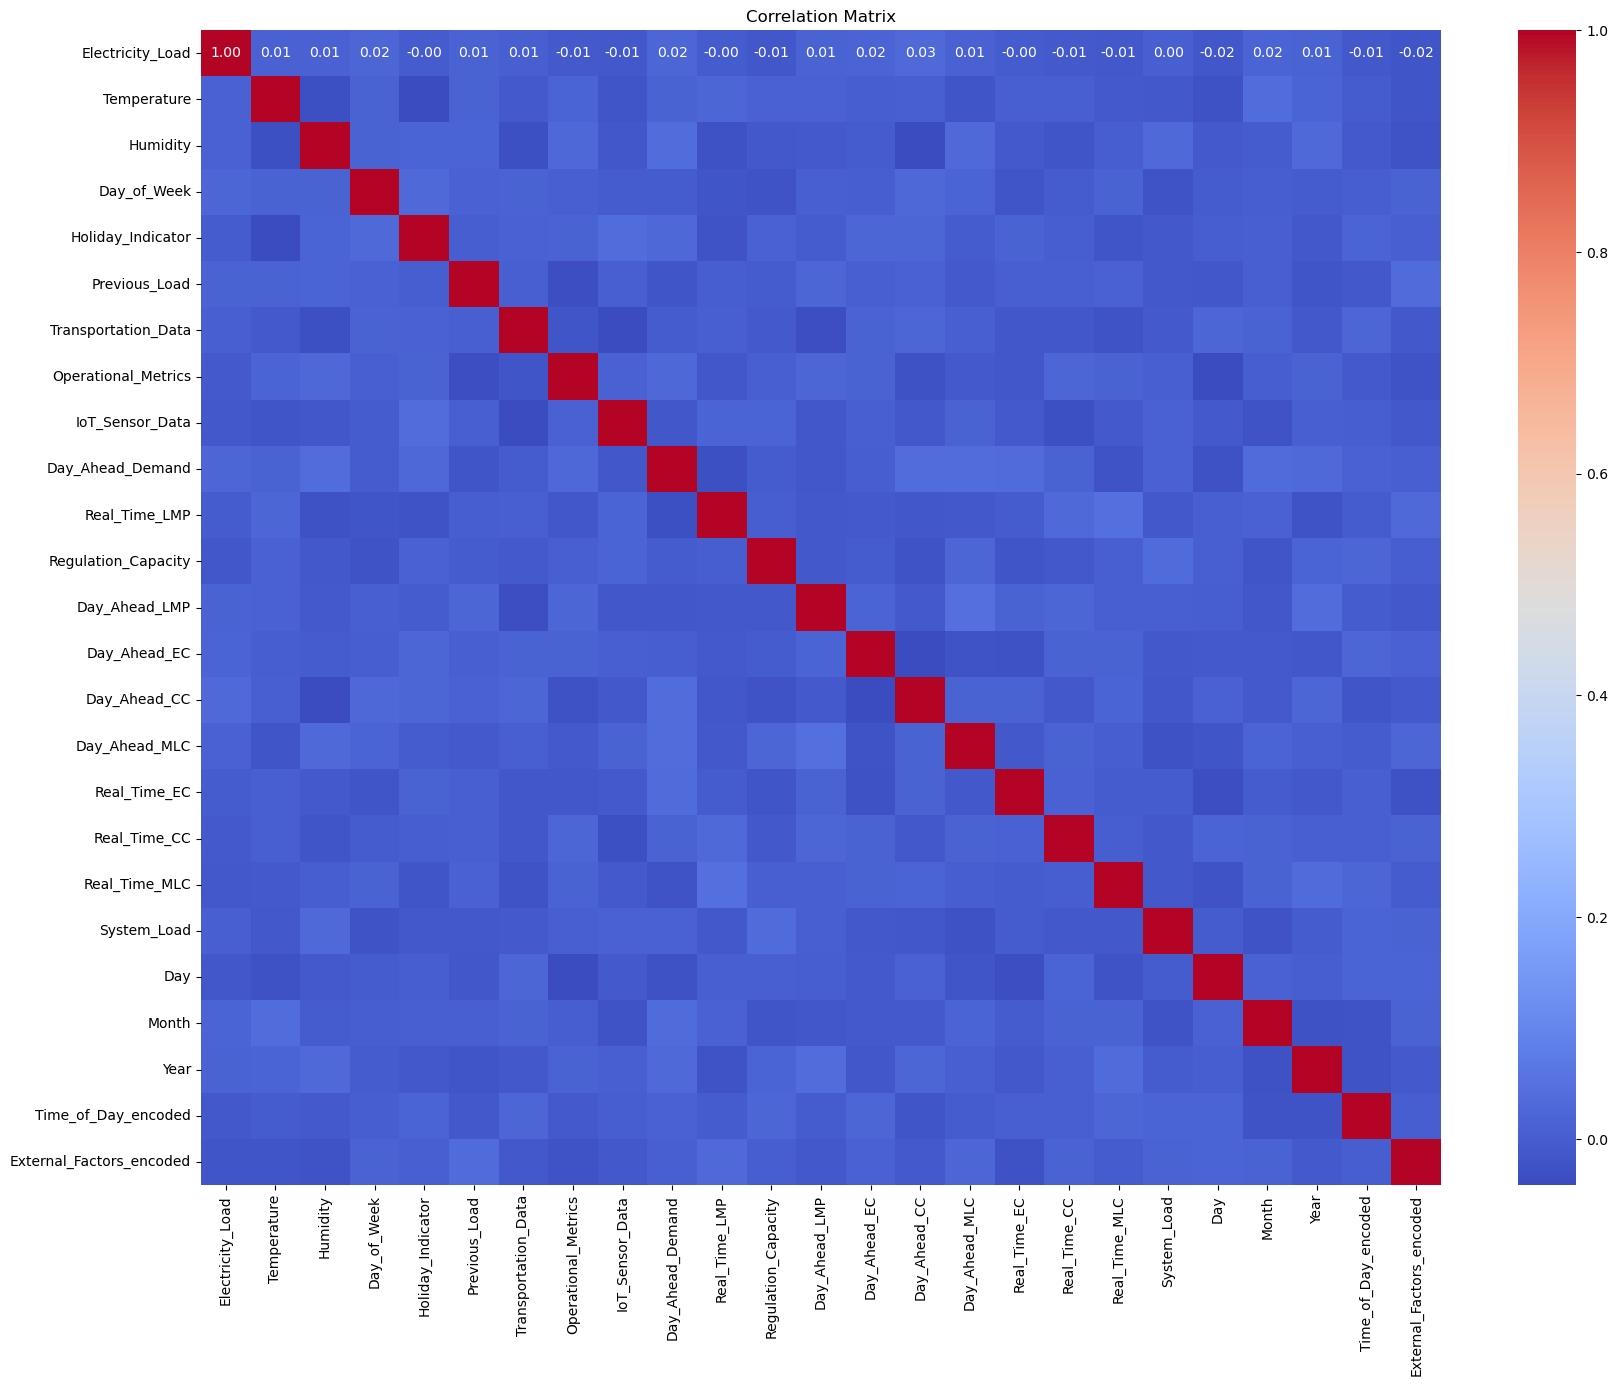

In [18]:
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(20, 15))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Scatter plot: To analyse the relationship between Electricity Load with other columns in the dataset

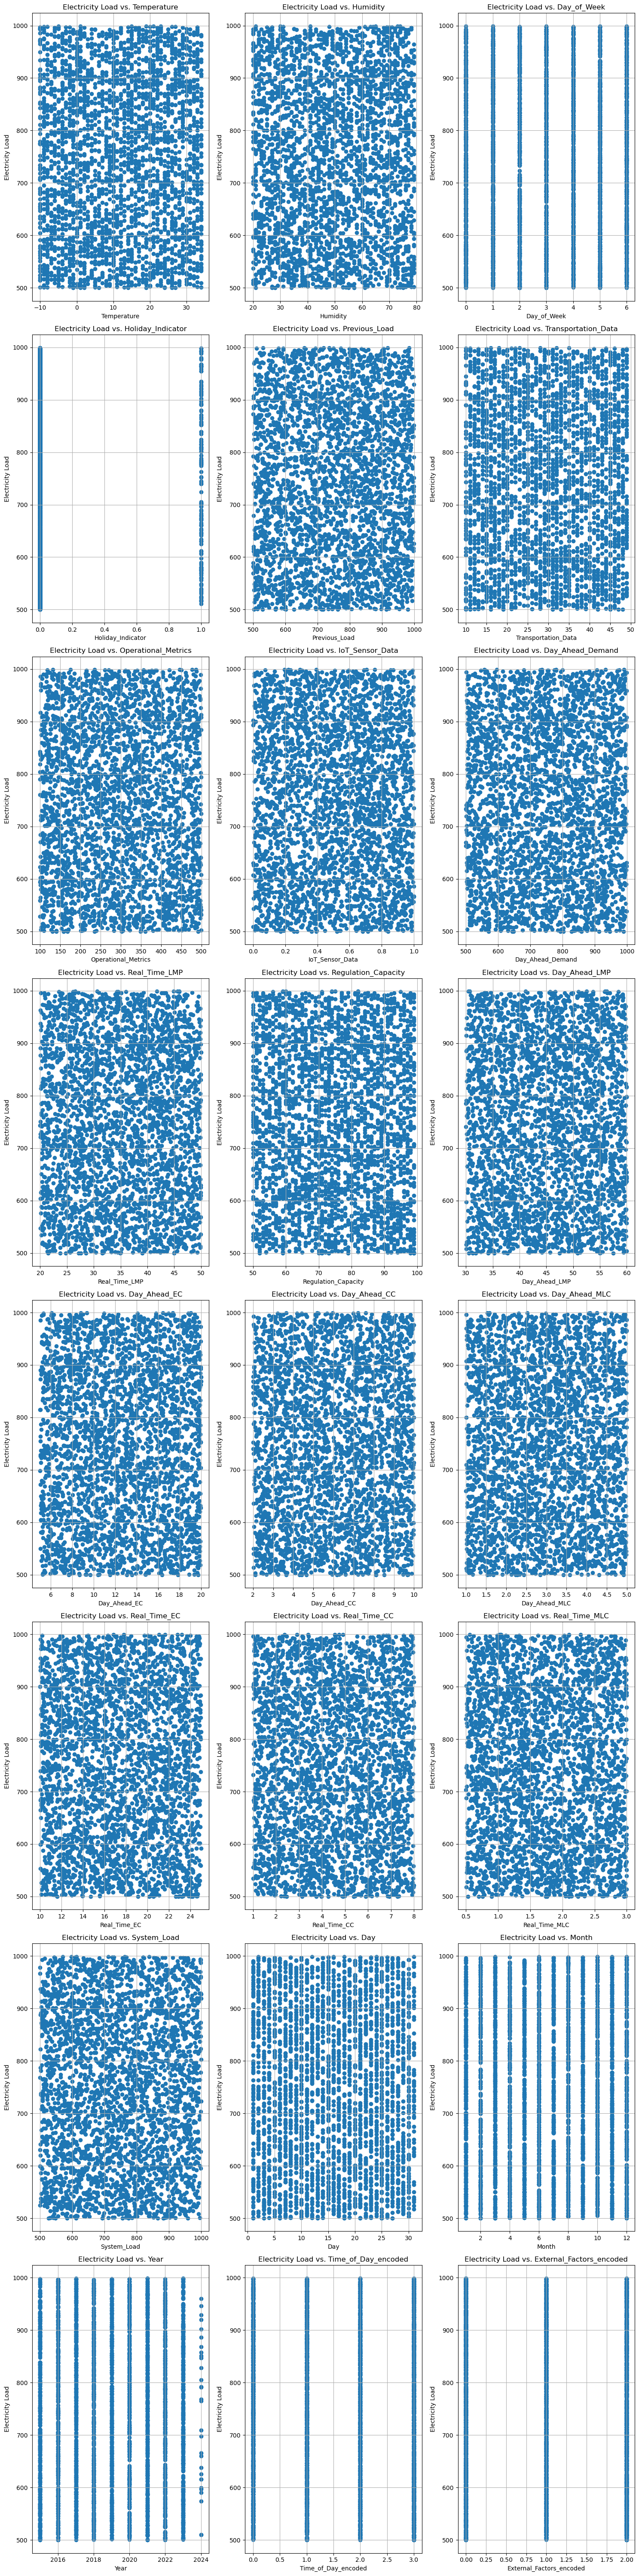

In [19]:
numerical_cols = [col for col in data.columns if col != 'Electricity_Load' and pd.api.types.is_numeric_dtype(data[col])]

fig, axes = plt.subplots(nrows=int((len(numerical_cols) - 1) / 3) + 1, ncols=3, figsize=(15, 60))  
for i, col in enumerate(numerical_cols):
    ax = axes.flat[i]
    ax.scatter(data[col], data['Electricity_Load'])  
    ax.set_xlabel(col)
    ax.set_ylabel('Electricity Load')
    ax.set_title('Electricity Load vs. {}'.format(col))
    ax.grid(True)

for ax in axes.flat[len(numerical_cols):]:
    ax.axis('off')

plt.tight_layout() 
plt.show()


## Performing time series analysis on the 'Electricity_Load' variable: Plotting the time series data and Decomposing the time series to observe trend, seasonality, and residuals

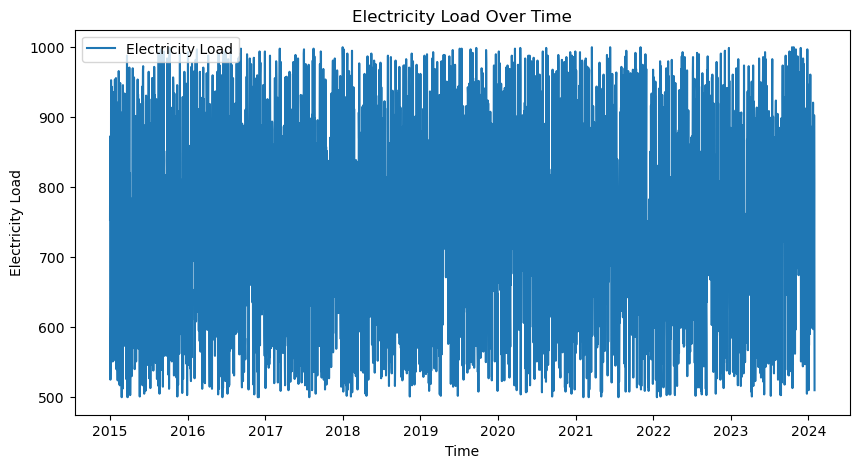

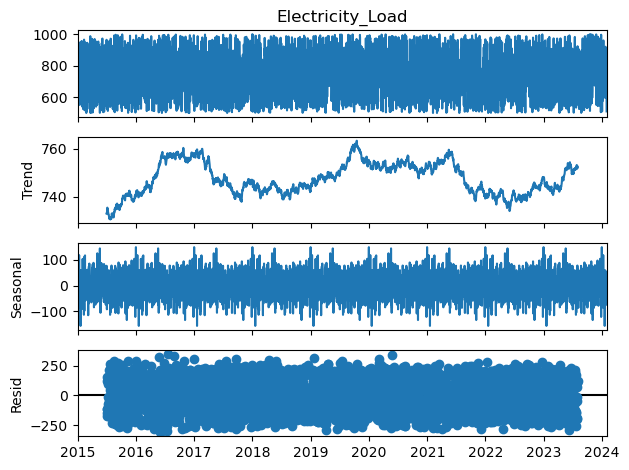

In [20]:
load_data = data.set_index('Timestamp')

plt.figure(figsize=(10,5))
plt.plot(load_data['Electricity_Load'], label='Electricity Load')
plt.title('Electricity Load Over Time')
plt.xlabel('Time')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(load_data['Electricity_Load'], model='additive', period=365)
result.plot()
plt.show()

## Identifying any seasonal patterns in the electricity load time series:  The monthly average electricity load over time, highlighting any long-term seasonal trends is analysed and the distribution of electricity load for each month, revealing seasonal patterns is analysed.

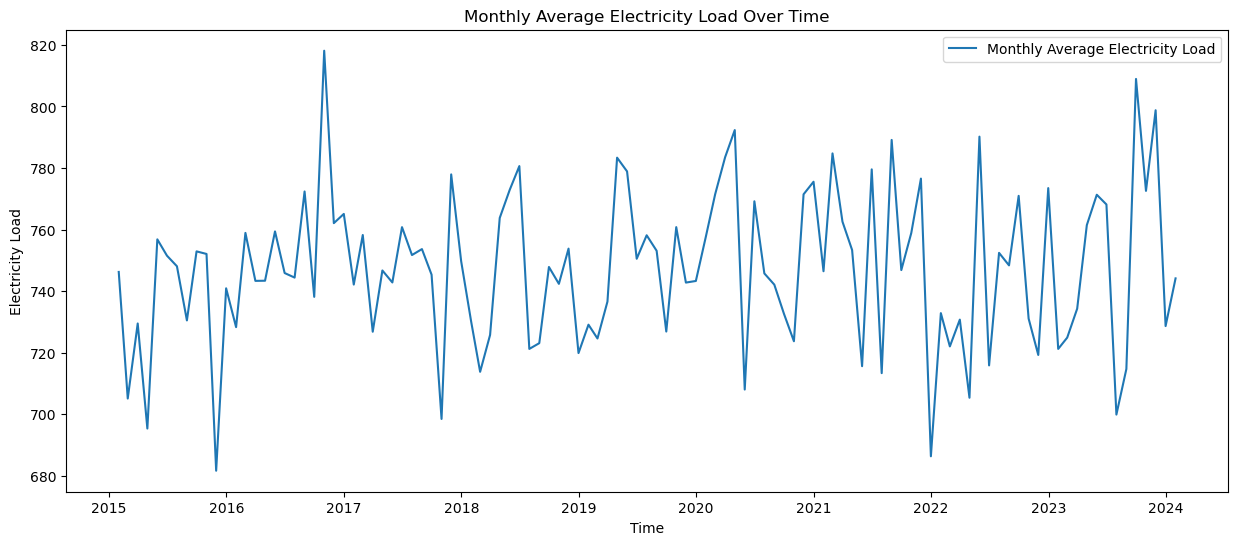

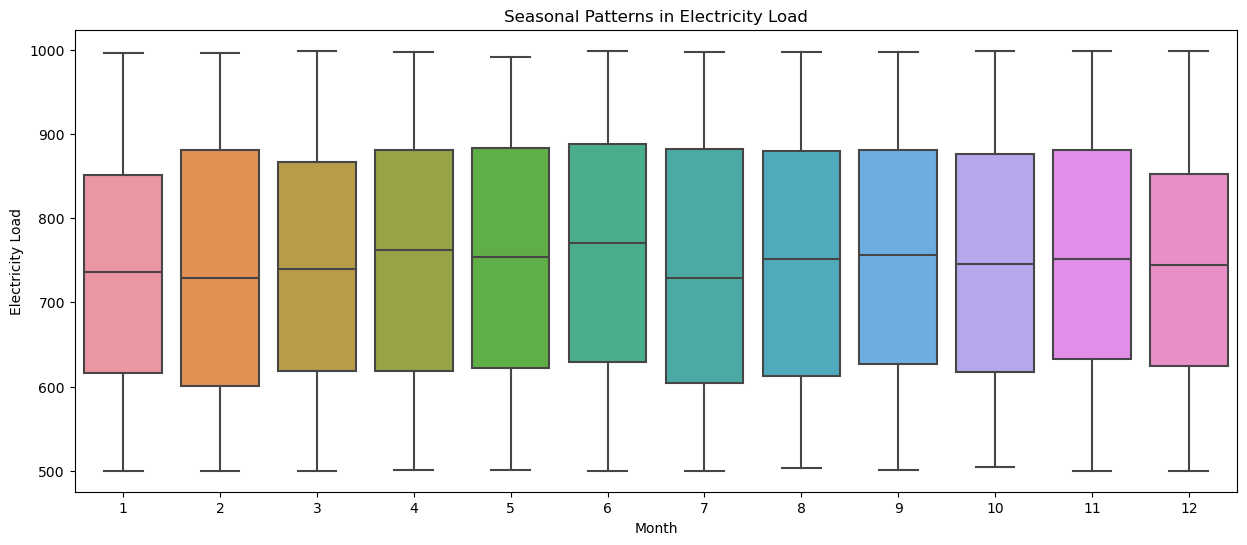

In [21]:
monthly_load = load_data['Electricity_Load'].resample('ME').mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_load, label='Monthly Average Electricity Load')
plt.title('Monthly Average Electricity Load Over Time')
plt.xlabel('Time')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(x=load_data.index.month, y=load_data['Electricity_Load'])
plt.title('Seasonal Patterns in Electricity Load')
plt.xlabel('Month')
plt.ylabel('Electricity Load')
plt.show()

## Grouping the data by month and calculating the mean electricity load for each month and Sorting the months by mean electricity load in descending order to identify peak load months

In [22]:

monthly_load_mean = load_data['Electricity_Load'].groupby(load_data.index.month).mean()

peak_load_months = monthly_load_mean.sort_values(ascending=False)

print(peak_load_months)

Timestamp
6     758.025926
5     755.125448
11    753.829630
9     752.296296
10    750.913978
4     749.474074
8     747.469534
12    742.566308
3     741.480287
2     740.641732
1     737.831715
7     737.247312
Name: Electricity_Load, dtype: float64


The peak load months based on the seasonal patterns are June, May, and November, with June having the highest average electricity load.

## Analyzing Autocorrelation in Electricity Load Data: To investigate the presence and patterns of dependence within the electricity load time series.

<Figure size 640x480 with 0 Axes>

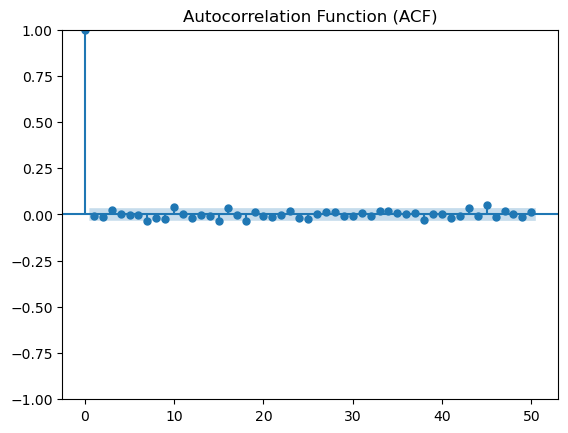

<Figure size 640x480 with 0 Axes>

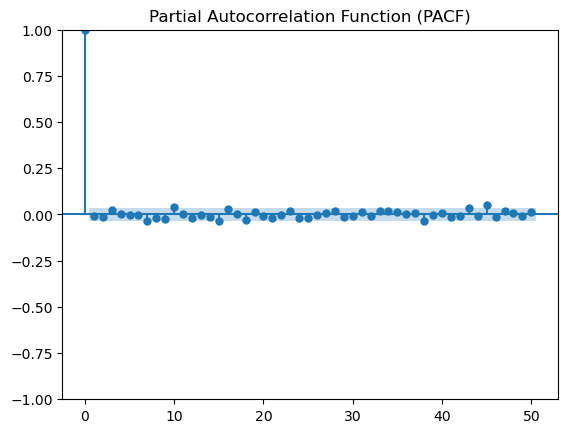

In [23]:
plt.figure(facecolor='white')

plot_acf(load_data['Electricity_Load'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(facecolor='white')
plot_pacf(load_data['Electricity_Load'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## Trend analysis: Original electricity load time series and the moving average (with a 30-day window) is analysed.

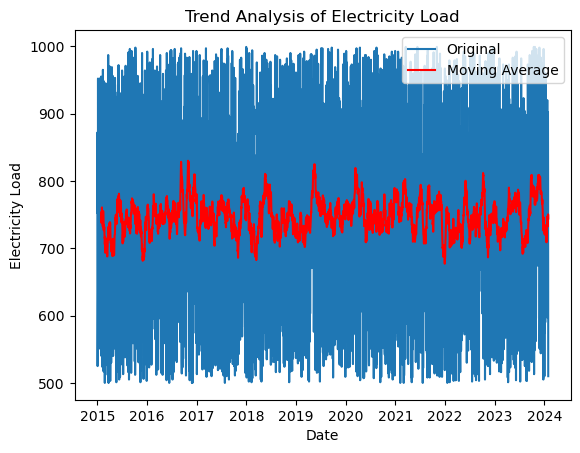

In [24]:
plt.figure(facecolor='white')

load_data['Moving_Average'] = load_data['Electricity_Load'].rolling(window=30).mean()
plt.plot(load_data['Electricity_Load'], label='Original')
plt.plot(load_data['Moving_Average'], label='Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.title('Trend Analysis of Electricity Load')
plt.legend()
plt.show()

# Developing Forecast models

## 1.Forecasting Energy demand using LSTM

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 - 3s - 74ms/step - loss: 0.2961
Epoch 2/50
37/37 - 0s - 2ms/step - loss: 0.2107
Epoch 3/50
37/37 - 0s - 3ms/step - loss: 0.1402
Epoch 4/50
37/37 - 0s - 2ms/step - loss: 0.1042
Epoch 5/50
37/37 - 0s - 2ms/step - loss: 0.0973
Epoch 6/50
37/37 - 0s - 2ms/step - loss: 0.0957
Epoch 7/50
37/37 - 0s - 3ms/step - loss: 0.0943
Epoch 8/50
37/37 - 0s - 3ms/step - loss: 0.0931
Epoch 9/50
37/37 - 0s - 3ms/step - loss: 0.0920
Epoch 10/50
37/37 - 0s - 2ms/step - loss: 0.0911
Epoch 11/50
37/37 - 0s - 2ms/step - loss: 0.0903
Epoch 12/50
37/37 - 0s - 3ms/step - loss: 0.0896
Epoch 13/50
37/37 - 0s - 3ms/step - loss: 0.0891
Epoch 14/50
37/37 - 0s - 3ms/step - loss: 0.0886
Epoch 15/50
37/37 - 0s - 2ms/step - loss: 0.0883
Epoch 16/50
37/37 - 0s - 2ms/step - loss: 0.0880
Epoch 17/50
37/37 - 0s - 2ms/step - loss: 0.0878
Epoch 18/50
37/37 - 0s - 3ms/step - loss: 0.0876
Epoch 19/50
37/37 - 0s - 2ms/step - loss: 0.0875
Epoch 20/50
37/37 - 0s - 2ms/step - loss: 0.0874
Epoch 21/50
37/37 - 0s - 2ms

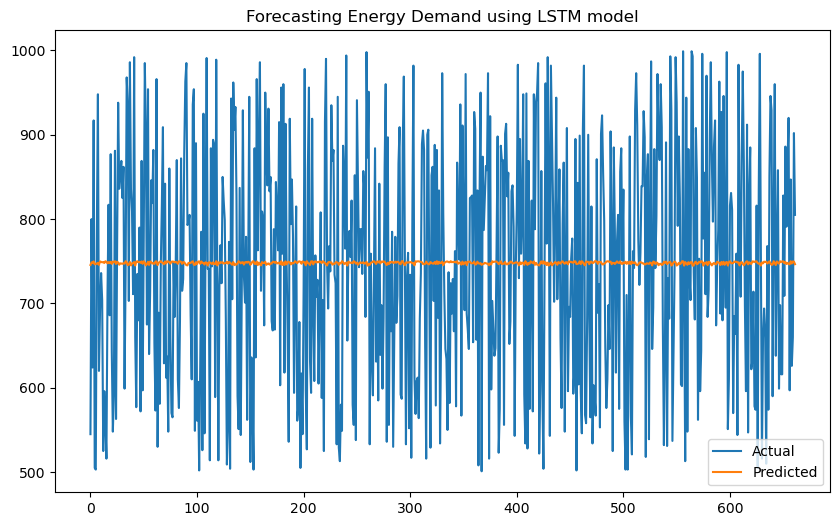

In [25]:
values = data['Electricity_Load'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
train_size = int(len(scaled_values) * 0.8)
train, test = scaled_values[0:train_size], scaled_values[train_size:len(scaled_values)]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Building the LSTM model
model = Sequential([LSTM(50, activation='relu', input_shape=(1, look_back)), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=2)

# Make predictions
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform([y_test])
y_pred = scaler.inverse_transform(y_pred)

# Model Evaluation
rmse = sqrt(mean_squared_error(y_test[0], y_pred[:,0]))
mae = mean_absolute_error(y_test[0], y_pred[:,0])
mape = np.mean(np.abs((y_test[0] - y_pred[:,0]) / y_test[0])) * 100
r2 = r2_score(y_test[0], y_pred[:,0])
evs = explained_variance_score(y_test[0], y_pred[:,0])
max_err = max_error(y_test[0], y_pred[:,0])

# Plotting the forecast against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[0], label='Actual')
plt.plot(y_pred[:,0], label='Predicted')
plt.title('Forecasting Energy Demand using LSTM model')
plt.legend()
plt.show()


## 2.Forecasting Energy Demand using VAR model

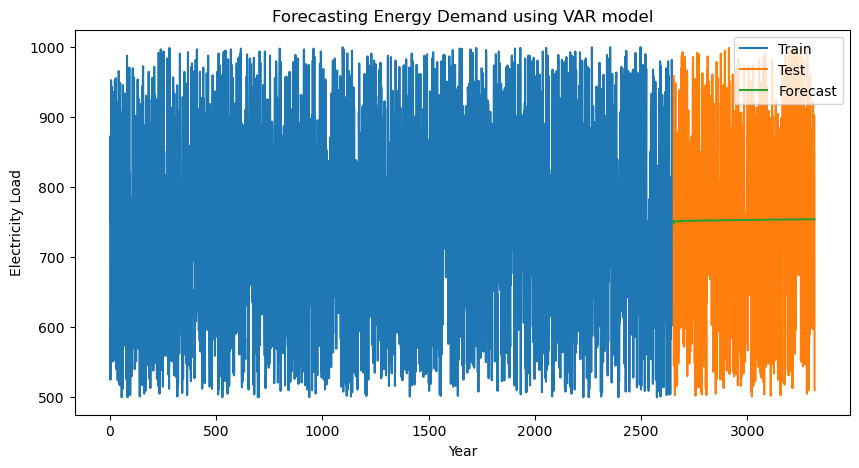

In [26]:
# Select relevant columns for VAR model
var_data = data[['Electricity_Load', 'Temperature', 'Humidity', 'Day_of_Week', 'Holiday_Indicator', 'Previous_Load', 'Transportation_Data', 'Operational_Metrics', 'IoT_Sensor_Data', 'Day_Ahead_Demand', 'Real_Time_LMP', 'Regulation_Capacity', 'Day_Ahead_LMP', 'Day_Ahead_EC', 'Day_Ahead_CC', 'Day_Ahead_MLC', 'Real_Time_EC', 'Real_Time_CC', 'Real_Time_MLC', 'System_Load', 'Day', 'Month', 'Year']
]

# Split the data into train and test sets
train, test = train_test_split(var_data, test_size=0.2, shuffle=False)

# Fit the VAR model
model = VAR(train)
model_fitted = model.fit()

# Forecast
forecast_input = train.values[-model_fitted.k_ar:]
forecast = model_fitted.forecast(y=forecast_input, steps=len(test))
forecast_data = pd.DataFrame(forecast, index=test.index, columns=train.columns)

# MODEL EVALUATION
var_rmse = np.sqrt(mean_squared_error(test['Electricity_Load'], forecast_data['Electricity_Load']))
var_mae = mean_absolute_error(test['Electricity_Load'], forecast_data['Electricity_Load'])
var_mape = np.mean(np.abs((test['Electricity_Load'] - forecast_data['Electricity_Load']) / test['Electricity_Load'])) * 100
var_r2 = r2_score(test['Electricity_Load'], forecast_data['Electricity_Load'])
var_evs = explained_variance_score(test['Electricity_Load'], forecast_data['Electricity_Load'])
var_max_err = max_error(test['Electricity_Load'], forecast_data['Electricity_Load'])

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.title('Forecasting Energy Demand using VAR model')
plt.plot(train.index, train['Electricity_Load'], label='Train')
plt.plot(test.index, test['Electricity_Load'], label='Test')
plt.plot(forecast_data.index, forecast_data['Electricity_Load'], label='Forecast')
plt.legend()
plt.xlabel('Year')  # Change to 'Year' if you only want to show years
plt.ylabel('Electricity Load')
plt.show()


## 3.Forecasting Energy Demand using SARIMA model

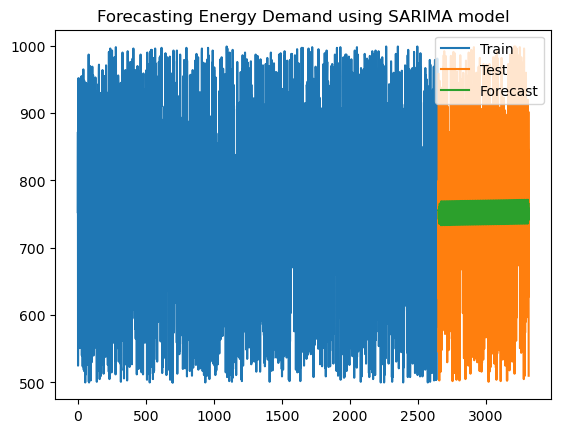

In [27]:
electricity_load = data['Electricity_Load']
train_size = int(len(electricity_load) * 0.8)
train, test = electricity_load[:train_size], electricity_load[train_size:]

# Fit the SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
sarima_mae = mean_absolute_error(test, forecast)
sarima_mape = np.mean(np.abs((test - forecast) / test)) * 100
sarima_r2 = r2_score(test, forecast)
sarima_evs = explained_variance_score(test, forecast)
sarima_max_err = max_error(test, forecast)
mse = mean_squared_error(test, forecast)
sarima_rmse = np.sqrt(mse)

# Plot the results
plt.figure(facecolor='white')
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Forecasting Energy Demand using SARIMA model')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

## 4.Forecasting Energy Demand using SVR model

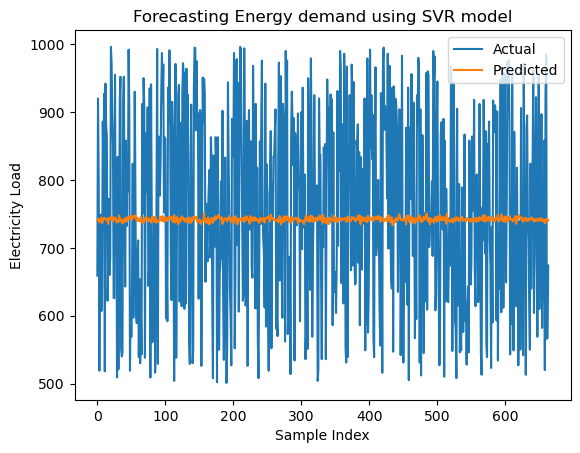

In [28]:
features = ['Temperature', 'Humidity', 'Day_of_Week', 'Time_of_Day', 'Holiday_Indicator', 'Previous_Load', 'Transportation_Data', 'Operational_Metrics', 'IoT_Sensor_Data', 'External_Factors', 'Day_Ahead_Demand', 'Real_Time_LMP', 'Regulation_Capacity', 'Day_Ahead_LMP', 'Day_Ahead_EC', 'Day_Ahead_CC', 'Day_Ahead_MLC', 'Real_Time_EC', 'Real_Time_CC', 'Real_Time_MLC']
target = 'Electricity_Load'

X = data[features]
y = data[target]

X = pd.get_dummies(X, columns=['Time_of_Day', 'External_Factors'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_test)

plt.figure(facecolor='white')
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Electricity Load')
plt.title('Forecasting Energy demand using SVR model')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
svr_rmse = np.sqrt(mse)
svr_mae = mean_absolute_error(y_test, y_pred)
svr_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
svr_r2 = r2_score(y_test, y_pred)
svr_evs = explained_variance_score(y_test, y_pred)
svr_max_err = max_error(y_test, y_pred)

## 5.Forecasting Energy demand using ARIMA Model

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


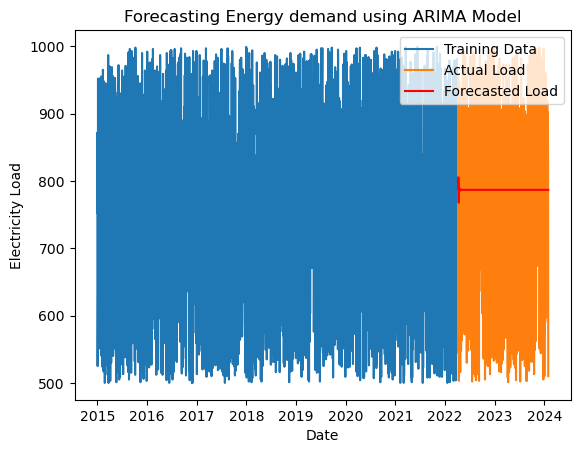

In [29]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Splitting the data into training and testing sets
train_size = int(len(load_data) * 0.8)
train, test = load_data['Electricity_Load'][:train_size], load_data['Electricity_Load'][train_size:]

# Fitting the ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))
arima_rmse = calculate_rmse(test, forecast)
arima_mae = mean_absolute_error(test, forecast)
arima_mape = np.mean(np.abs((test - forecast) / test)) * 100
arima_r2 = r2_score(test, forecast)
arima_evs = explained_variance_score(test, forecast)
arima_max_err = max_error(test, forecast)

# Plotting the results
plt.figure(facecolor='white')
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Load')
plt.plot(test.index, forecast, label='Forecasted Load', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.title('Forecasting Energy demand using ARIMA Model')
plt.legend()
plt.show()

## 6.Forecasting Energy demand using Holt Winters Model

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


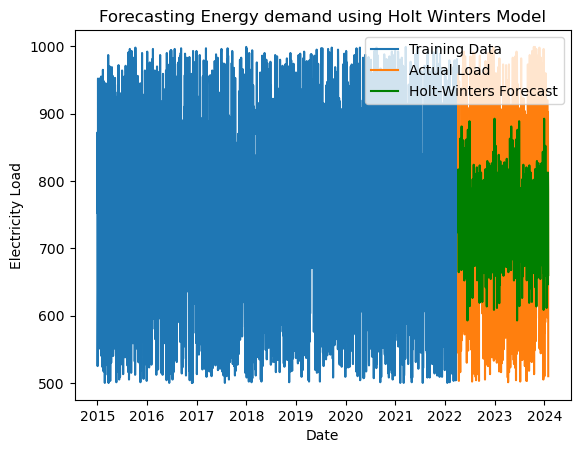

In [30]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Holt-Winters model
hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=365)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(steps=len(test))
hw_rmse = calculate_rmse(test, hw_forecast)
hw_mae = mean_absolute_error(test, hw_forecast)
hw_mape = np.mean(np.abs((test - hw_forecast) / test)) * 100
hw_r2 = r2_score(test, hw_forecast)
hw_evs = explained_variance_score(test, hw_forecast)
hw_max_err = max_error(test, hw_forecast)

# Plotting the results
plt.figure(facecolor='white')
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Load')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.title('Forecasting Energy demand using Holt Winters Model')
plt.legend()
plt.show()

## 7.Forecasting Energy demand using XGBoost Model

In [31]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


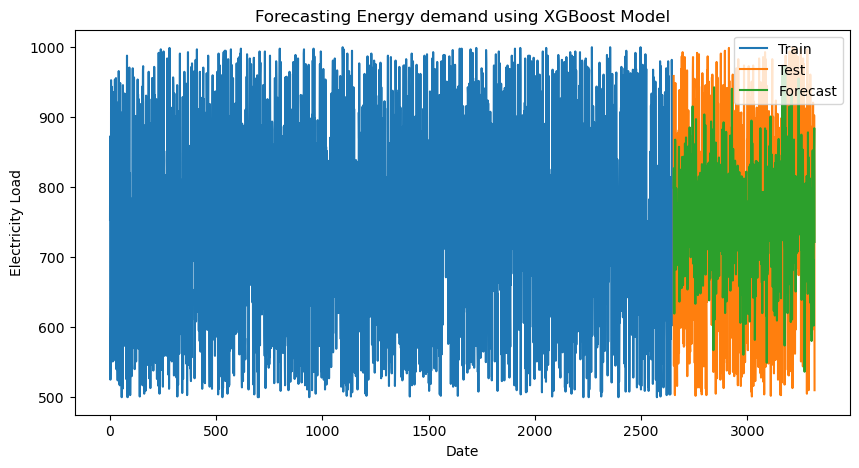

In [32]:


xgb_data = data[['Electricity_Load', 'Temperature', 'Humidity', 'Day_of_Week', 'Holiday_Indicator', 'Previous_Load', 'Transportation_Data', 'Operational_Metrics', 'IoT_Sensor_Data', 'Day_Ahead_Demand', 'Real_Time_LMP', 'Regulation_Capacity', 'Day_Ahead_LMP', 'Day_Ahead_EC', 'Day_Ahead_CC', 'Day_Ahead_MLC', 'Real_Time_EC', 'Real_Time_CC', 'Real_Time_MLC', 'System_Load', 'Day', 'Month', 'Year']
]

# Split the data into train and test sets
X = xgb_data.drop(columns=['Electricity_Load'])
y = xgb_data['Electricity_Load']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predict
xgb_forecast = xgb_model.predict(X_test)

# Calculate RMSE for XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_mape = np.mean(np.abs((y_test - xgb_forecast) / y_test)) * 100
xgb_r2 = r2_score(y_test, xgb_forecast)
xgb_evs = explained_variance_score(y_test, xgb_forecast)
xgb_max_err = max_error(y_test, xgb_forecast)


# Plot the forecast
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, xgb_forecast, label='Forecast')
plt.legend()
plt.title('Forecasting Energy demand using XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.show()

In [33]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [34]:


# Create a list of lists to store the table data
table_data = [["Algorithm", "RMSE", "MAE", "MAPE", "R-squared", "Explained Variance", "Max Error"]]

# Append the results for each algorithm to the table_data list
table_data.append(["LSTM", rmse, mae, f"{mape:.2f}%", f"{r2:.2f}", f"{evs:.2f}", max_err])
table_data.append(["VAR", var_rmse, var_mae, f"{var_mape:.2f}%", f"{var_r2:.2f}", f"{var_evs:.2f}", var_max_err])
table_data.append(["SARIMA", rmse, sarima_mae, f"{sarima_mape:.2f}%", f"{sarima_r2:.2f}", f"{sarima_evs:.2f}", sarima_max_err])
table_data.append(["SVR", rmse, svr_mae, f"{svr_mape:.2f}%", f"{svr_r2:.2f}", f"{svr_evs:.2f}", svr_max_err])
table_data.append(["ARIMA", arima_rmse, arima_mae, f"{arima_mape:.2f}%", f"{arima_r2:.2f}", f"{arima_evs:.2f}", arima_max_err])
table_data.append(["Holt-Winters", hw_rmse, hw_mae, f"{hw_mape:.2f}%", f"{hw_r2:.2f}", f"{hw_evs:.2f}", hw_max_err])
table_data.append(["XGBoost", xgb_rmse, xgb_mae, f"{xgb_mape:.2f}%", f"{xgb_r2:.2f}", f"{xgb_evs:.2f}", xgb_max_err])

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+--------------+---------+---------+--------+-------------+----------------------+-------------+
| Algorithm    |    RMSE |     MAE | MAPE   |   R-squared |   Explained Variance |   Max Error |
+==============+=========+=========+========+=============+======================+=============+
| LSTM         | 141.473 | 121.723 | 17.29% |       -0    |                -0    |     249.876 |
+--------------+---------+---------+--------+-------------+----------------------+-------------+
| VAR          | 141.837 | 122.03  | 17.45% |       -0    |                 0    |     251.804 |
+--------------+---------+---------+--------+-------------+----------------------+-------------+
| SARIMA       | 141.473 | 122.422 | 17.50% |       -0.01 |                -0.01 |     260.437 |
+--------------+---------+---------+--------+-------------+----------------------+-------------+
| SVR          | 141.473 | 126.445 | 17.40% |       -0.02 |                -0    |     256.111 |
+--------------+---------+----

In [35]:
data

Timestamp  Electricity_Load  Temperature  Humidity  Day_of_Week  \
0    2015-01-01               753            2        69            3   
1    2015-01-02               872           14        26            4   
2    2015-01-03               525           19        73            5   
3    2015-01-04               568           23        59            6   
4    2015-01-05               636           28        32            0   
...         ...               ...          ...       ...          ...   
3312 2024-01-26               626            7        78            4   
3313 2024-01-27               660           28        76            5   
3314 2024-01-28               902           -6        71            6   
3315 2024-01-29               805            8        50            0   
3316 2024-01-30               510           -2        69            1   

     Time_of_Day  Holiday_Indicator  Previous_Load  Transportation_Data  \
0      afternoon                  1            812                   25   
1        evening                  0            963                   25   
2      afternoon                  0            753                   11   
3        morning                  0            839                   16   
4      afternoon                  0            505                   24   
...          ...                ...            ...                  ...   
3312       night                  0            999                   21   
3313   afternoon                  0            589                   31   
3314     morning                  0            930                   37   
3315     morning                  0            809                   46   
3316       night                  0            765                   18   

      Operational_Metrics  ...  Day_Ahead_MLC Real_Time_EC  Real_Time_CC  \
0                     201  ...       1.568146    18.903664      4.407353   
1                     139  ...       4.317611    22.458212      5.615720   
2                     497  ...       3.776703    13.400587      1.741812   
3                     464  ...       1.900629    16.558408      3.974303   
4                     142  ...       2.949036    20.760512      4.140475   
...                   ...  ...            ...          ...           ...   
3312                  370  ...       4.431077    18.111913      2.602763   
3313                  328  ...       4.596308    22.941873      4.375059   
3314                  174  ...       1.941599    24.453996      7.705989   
3315                  300  ...       3.288789    17.424410      7.444762   
3316                  475  ...       3.143045    14.849659      1.863989   

      Real_Time_MLC  System_Load  Day  Month  Year  Time_of_Day_encoded  \
0          1.385887          518    1      1  2015                    0   
1          2.689898          503    2      1  2015                    1   
2          1.610319          897    3      1  2015                    0   
3          2.798738          526    4      1  2015                    2   
4          1.041746          958    5      1  2015                    0   
...             ...          ...  ...    ...   ...                  ...   
3312       2.682778          603   26      1  2024                    3   
3313       1.208422          966   27      1  2024                    0   
3314       1.280677          745   28      1  2024                    2   
3315       2.076614          698   29      1  2024                    2   
3316       2.956020          840   30      1  2024                    3   

      External_Factors_encoded  
0                            2  
1                            1  
2                            0  
3                            2  
4                            2  
...                        ...  
3312                         1  
3313                         1  
3314                         2  
3315                         0  
3316                         2  

[3317 rows x 28 c

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


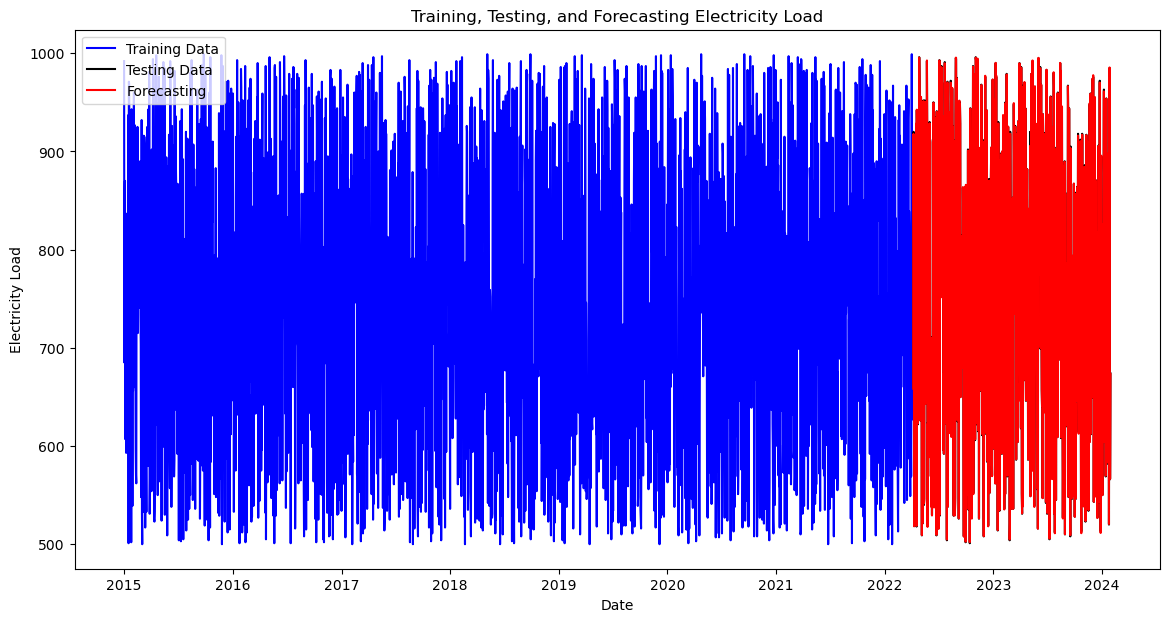

XGBoost Root Mean Square Error: 1.3527785928416065
XGBoost Mean Absolute Error: 0.8002946692776968
XGBoost Mean Absolute Percentage Error: 0.10803386436494164
XGBoost R-squared: 0.9999113546211277
XGBoost Explained Variance Score: 0.9999115915757772
XGBoost Max Error: 14.53204345703125


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:

# Define features and target
features = ['Day','Month','Year','Time_of_Day_encoded','Electricity_Load', 'Temperature', 'Humidity', 'Holiday_Indicator', 'Previous_Load', 'Transportation_Data', 'Operational_Metrics','System_Load','External_Factors_encoded'] 
target='Electricity_Load'
            
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print('Best parameters found: ', best_params)

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Combine the actual and predicted values for plotting
train_dates = data['Timestamp'][:len(y_train)]
test_dates = data['Timestamp'][len(y_train):len(y_train) + len(y_test)]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_dates, y_train, label='Training Data', color='blue')
plt.plot(test_dates, y_test, label='Testing Data', color='black')
plt.plot(test_dates, y_pred, label='Forecasting', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.title('Training, Testing, and Forecasting Electricity Load')
plt.legend()
plt.show()

# Evaluate the model
xgb_new_rmse = mean_squared_error(y_test, y_pred, squared=False)
xgb_new_mae = mean_absolute_error(y_test, y_pred)
xgb_new_mape = (abs((y_test - y_pred) / y_test).mean()) * 100
xgb_new_r2 = r2_score(y_test, y_pred)
xgb_new_evs = explained_variance_score(y_test, y_pred)
xgb_new_max_err = max_error(y_test, y_pred)

print('XGBoost Root Mean Square Error:', xgb_new_rmse)
print('XGBoost Mean Absolute Error:', xgb_new_mae)
print('XGBoost Mean Absolute Percentage Error:', xgb_new_mape)
print('XGBoost R-squared:', xgb_new_r2)
print('XGBoost Explained Variance Score:', xgb_new_evs)
print('XGBoost Max Error:', xgb_new_max_err)

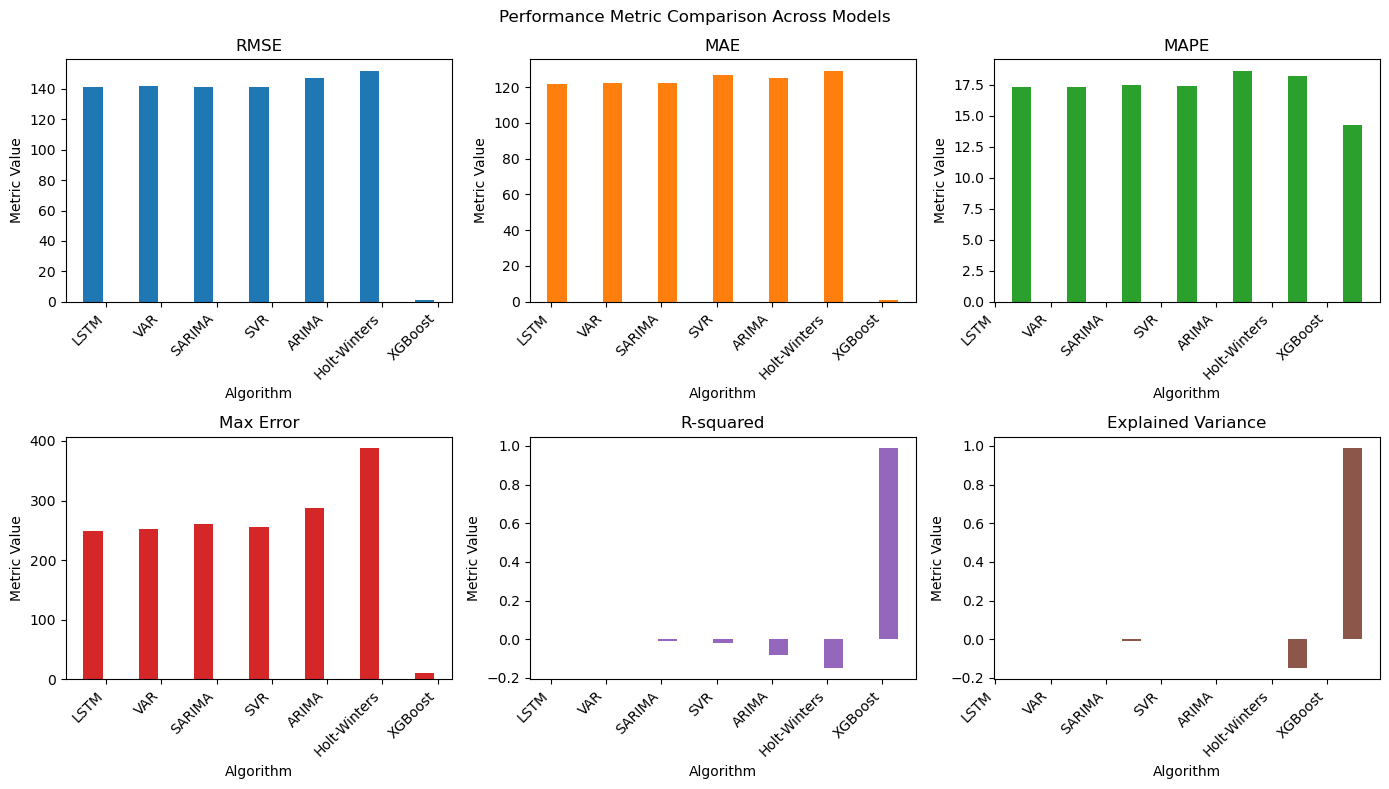

In [37]:

algorithms = ["LSTM", "VAR", "SARIMA", "SVR", "ARIMA", "Holt-Winters", "XGBoost"]
performance_metrics = {
    "RMSE": [141.491, 141.781, 141.491, 141.491, 147.042, 151.81, 1.442],
    "MAE": [121.732, 121.992, 122.422, 126.445, 125.012, 129.025, 1.053],
    "MAPE": [17.33, 17.31, 17.50, 17.40, 18.63, 18.19, 14.29],
    "Max Error": [249.047, 251.987, 260.437, 256.111, 287.414, 387.528, 10.5],
    "R-squared": [-0.0, -0.0, -0.01, -0.02, -0.08, -0.15, 0.99],
    "Explained Variance": [-0.0, -0.0, -0.01, -0.0, 0.0, -0.15, 0.99]
}

metrics_to_visualize = ["RMSE", "MAE", "MAPE", "Max Error", "R-squared", "Explained Variance"]

num_rows = 2
num_cols = int(len(metrics_to_visualize) / num_rows) + (len(metrics_to_visualize) % num_rows > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))  # Adjust figure size as needed

width = 0.35
for i, metric in enumerate(metrics_to_visualize):
    row = i // num_cols
    col = i % num_cols
    x = [j - width/len(metrics_to_visualize) + col * width for j in range(len(algorithms))]
    axes[row, col].bar(x, performance_metrics[metric], width, label=metric, color='C' + str(i))
    axes[row, col].set_xlabel('Algorithm')
    axes[row, col].set_ylabel('Metric Value')
    axes[row, col].set_title(metric)
    axes[row, col].set_xticks([j + width/2 for j in range(len(algorithms))], algorithms, rotation=45, ha='right') 

fig.suptitle('Performance Metric Comparison Across Models', fontsize=12) 
plt.tight_layout()
plt.show()


In [38]:
from joblib import dump 

dump(best_xgb_model, "Energy_demand_forecast_model.pkl" )

['Energy_demand_forecast_model.pkl']